In [ ]:
!nvidia-smi

Wed Mar 31 07:25:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!pip install tweet-preprocessor

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install tensorflow-addons
import tensorflow_addons as tfa
import re
import preprocessor as p
import string
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
!pip install -q kaggle
from google.colab import files
files.upload()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"agungpribadi","key":"65b1b494338cd55e491680d54c0e761d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d datatattle/covid-19-nlp-text-classification
!mkdir corona
!unzip covid-19-nlp-text-classification.zip -d corona
!ls corona

kaggle.json
covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘corona’: File exists
Archive:  covid-19-nlp-text-classification.zip
replace corona/Corona_NLP_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace corona/Corona_NLP_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Corona_NLP_test.csv  Corona_NLP_train.csv


In [ ]:
train_data = pd.read_csv('corona/Corona_NLP_train.csv', encoding='L1')
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


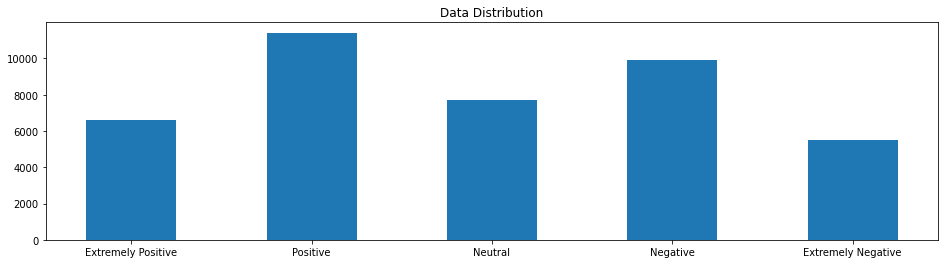

18046 15398 7713


In [ ]:

ps = PorterStemmer()
train_data.head()

x = []
y = []
jumlahData = 0
list_kata = []

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

STOPWORDS = set(stopwords.words('english'))

nExPositive = 0
nPositive = 0
nExNegative = 0
nNegative = 0
nNeutral = 0
pattern=r'[$+0-9]'
for _, data in train_data.iterrows():
  text = p.clean(data[4])
  text = text.split(' ')
  textstr = ''
  for j in range(len(text)):
    textstr += ' '+ps.stem(text[j])
  text = textstr.strip()
  text = re.sub(pattern,'', text)
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)

  x.append(text)
  labelku = ''

  if(data[5] == 'Positive'):
    nPositive += 1
  elif(data[5] == 'Negative'):
    nNegative += 1

  if(data[5] == 'Extremely Positive'):
    nExPositive += 1
    labelku = 'Positive'
  elif(data[5] == 'Extremely Negative'):
    nExNegative += 1
    labelku = 'Negative'
  elif(data[5] == 'Neutral'):
    nNeutral += 1
    labelku = data[5]
  else:
    labelku = data[5]
  y.append(labelku)
  


fig = plt.figure(figsize=(16, 4))
plt.bar(x=['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'],
        height=[nExPositive, nPositive, nNeutral, nNegative, nExNegative],
        width=0.5)
plt.title('Data Distribution')
plt.show()

dataPosCampuran = nExPositive + nPositive
dataNegCampuran = nExNegative + nNegative
print(dataPosCampuran, dataNegCampuran, nNeutral)



(23139,)
(23139,)


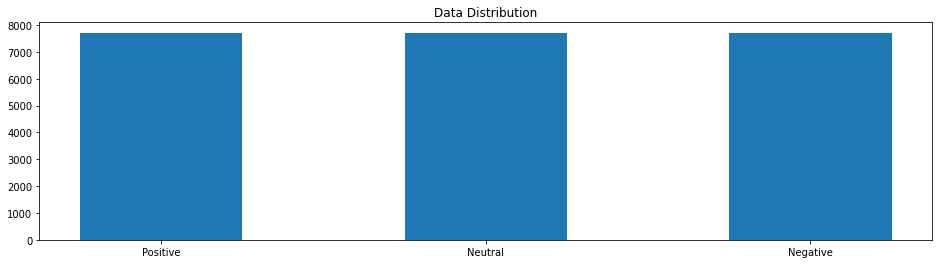

In [ ]:
ctrPos = 0
ctrNeu = 0
ctrNeg = 0

train = []
label = []
for i in range(len(x)):
  add = 0
  if(ctrPos < nNeutral and y[i] == 'Positive'):
    add = 1
    ctrPos += 1
  if(ctrNeg < nNeutral and y[i] == 'Negative'):
    add = 1
    ctrNeg += 1
  if(ctrNeu < nNeutral and y[i] == 'Neutral'):
    add = 1
    ctrNeu += 1
  if(add == 1):
    train.append(x[i])
    label.append(y[i])

train = np.array(train)
label = np.array(label)
print(train.shape)
print(label.shape)

fig = plt.figure(figsize=(16, 4))
plt.bar(x=['Positive', 'Neutral', 'Negative'],
        height=[ctrPos, ctrNeu, ctrNeg],
        width=0.5)
plt.title('Data Distribution')
plt.show()

In [ ]:
for i in range(len(train)):
  list_kata.append(train[i].split(' '))

print(train)
print(label)

max_len_pad = 0
for i in range(len(list_kata)):
  if(max_len_pad < len(list_kata[i])):
    max_len_pad = len(list_kata[i])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train) 

vocab_size = len(tokenizer.word_index) + 1
sekuens = tokenizer.texts_to_sequences(train)
padded = pad_sequences(sekuens, maxlen=max_len_pad, padding='post') 


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
label = labelencoder.fit_transform(label)
label = tf.keras.utils.to_categorical(label)

kalimat_latih, kalimat_test, y_latih, y_test = train_test_split(padded, label, test_size=0.2)
print(kalimat_latih)
print(y_latih)

[''
 'advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order'
 'coronaviru australia woolworth give elderly disabl dedic shop hour amid covid outbreak'
 ... 'doe supermarket nearbi get covid'
 'airlin pilot offer stock supermarket shelv lockdown'
 'wrong smell hand sanit start turn']
['Neutral' 'Positive' 'Positive' ... 'Neutral' 'Neutral' 'Neutral']
[[ 1260   358    21 ...     0     0     0]
 [11754 11755   330 ...     0     0     0]
 [   88    15     3 ...     0     0     0]
 ...
 [    4   806    30 ...     0     0     0]
 [  124  2633  1256 ...     0     0     0]
 [ 1317    41     3 ...     0     0     0]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
print(kalimat_latih.shape)

(18511, 38)


In [ ]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 64, input_length=max_len_pad))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model_conv.add(tf.keras.layers.BatchNormalization(axis=1))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_conv.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5, recurrent_dropout = 0.5)))
model_conv.add(tf.keras.layers.Dense(64))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(32))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(16))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model_conv.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 38, 64)            1581376   
_________________________________________________________________
dropout_12 (Dropout)         (None, 38, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 128)           41088     
_________________________________________________________________
batch_normalization_1 (Batch (None, 34, 128)           136       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [ ]:
history = model_conv.fit(kalimat_latih, y_latih, validation_data=(kalimat_test, y_test), epochs=30, batch_size=128, verbose=1)

Epoch 1/30
145/145 [==============================] - 17s 86ms/step - loss: 1.2480 - accuracy: 0.3828 - val_loss: 1.0697 - val_accuracy: 0.4557
Epoch 2/30
145/145 [==============================] - 12s 81ms/step - loss: 1.0342 - accuracy: 0.4511 - val_loss: 1.0644 - val_accuracy: 0.4164
Epoch 3/30
145/145 [==============================] - 12s 80ms/step - loss: 0.9294 - accuracy: 0.5346 - val_loss: 1.2063 - val_accuracy: 0.5236
Epoch 4/30
145/145 [==============================] - 12s 81ms/step - loss: 0.7557 - accuracy: 0.6592 - val_loss: 1.0269 - val_accuracy: 0.6867
Epoch 5/30
145/145 [==============================] - 12s 81ms/step - loss: 0.5447 - accuracy: 0.8084 - val_loss: 0.7824 - val_accuracy: 0.7828
Epoch 6/30
145/145 [==============================] - 12s 81ms/step - loss: 0.4379 - accuracy: 0.8599 - val_loss: 0.8816 - val_accuracy: 0.7800
Epoch 7/30
145/145 [==============================] - 12s 81ms/step - loss: 0.3678 - accuracy: 0.8864 - val_loss: 0.9968 - val_accuracy:

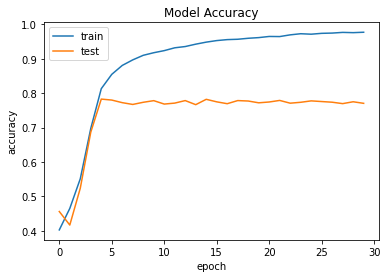

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

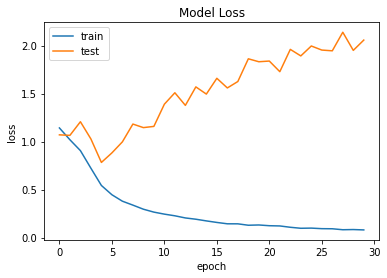

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()